In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch_optimizer as optim
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import random

import matplotlib.pyplot as plt
import time

from model import ConvNet, PoorNet
from CustomDataset import get_dataset
from CustomDataset import vec_trans

[nltk_data] Downloading package punkt to /nfs4/ushashi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))


LEARNINGRATE = 3e-3
GAMMA = 0.98

BATCHSIZE = 128
NUMEPOCHS = 20


dset = get_dataset('20news-bydate-train')
tset = get_dataset('20news-bydate-test')

### TRAIN VAL SPLIT

NUM_DATA_POINTS = len(dset)

indices = list(range(NUM_DATA_POINTS))
split = int(np.floor(0.2 * NUM_DATA_POINTS))
np.random.shuffle(indices)


train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_points = len(train_indices)
val_points = len(val_indices)
            
train_loader = torch.utils.data.DataLoader(dset, batch_size = BATCHSIZE, 
                                           sampler=train_sampler, num_workers=4)
validation_loader = torch.utils.data.DataLoader(dset, batch_size = BATCHSIZE,
                                                sampler=valid_sampler, num_workers=4)
test_loader = torch.utils.data.DataLoader(tset, batch_size = BATCHSIZE,
                                                num_workers=4)

print("Printing Train + Val Number of Documents Found")
print(NUM_DATA_POINTS)

Printing Train + Val Number of Documents Found
11314


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_slave = PoorNet(True, WINDOW=2)
print('Running on',device)
print('Building Slave model..')
model_slave.to(device)
print('Model Built.')

FILE = 'weights-poor/Model_best_val_quicksave.pt'

model_slave.load_state_dict(torch.load(FILE,map_location='cuda:0'))
model_slave.eval()


print('Initializing optimizer and scheduler..')

criterion = torch.nn.NLLLoss()
optimizer = optim.RAdam(model_slave.parameters(), lr = LEARNINGRATE)             # OR RAdam/DiffGrad/etc
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = GAMMA)

print('Optimizer and scheduler initialized.')

print('Printing Parameters')
for name, param in model_slave.named_parameters():
    if param.requires_grad:
        print(name)
print('---Printing Parameters Finished!---')


Running on cuda:0
Building Slave model..
Model Built.
Initializing optimizer and scheduler..
Optimizer and scheduler initialized.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
---Printing Parameters Finished!---


In [9]:
model_master = ConvNet(True)
print('Running on',device)
print('Building Master model..')
model_master.to(device)
print('Model Built.')

FILE_MASTER = 'weights/Model_quicksave40.pt'

model_master.load_state_dict(torch.load(FILE_MASTER,map_location='cuda:0'))
model_master.eval()


print('Printing Parameters')
for name, param in model_master.named_parameters():
    if param.requires_grad:
        print(name)
        #print(param.shape)
print('---Printing Parameters Finished!---')

Running on cuda:0
Building Master model..
Model Built.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
---Printing Parameters Finished!---


In [10]:
corr = 0.0
with torch.no_grad():
  for ib,sample in enumerate(test_loader):
    
    sample, target, path = sample
    data_input = torch.as_tensor(sample[:,:,:,:])
    data_output = torch.as_tensor(target)

    data_input = data_input.to(device, dtype=torch.float)
    data_output = data_output.to(device, dtype=torch.long)

    output = model_slave(data_input)
    _, preds = torch.max(output,dim=1)
    corr += (torch.sum(preds == data_output.data)).data.item()

print('Test Accuracy Slave: {:.2f}%'.format(corr*100.0/len(tset)))

Test Accuracy Slave: 58.50%


In [12]:
corr = 0.0
with torch.no_grad():
  for ib,sample in enumerate(test_loader):
    
    sample, target, path = sample
    data_input = torch.as_tensor(sample[:,:,:,:])
    data_output = torch.as_tensor(target)

    data_input = data_input.to(device, dtype=torch.float)
    data_output = data_output.to(device, dtype=torch.long)

    output = model_master(data_input)
    _, preds = torch.max(output,dim=1)
    corr += (torch.sum(preds == data_output.data)).data.item()

print('Test Accuracy Master: {:.2f}%'.format(corr*100.0/len(tset)))

Test Accuracy Master: 78.51%


In [13]:
from keras import backend as K
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, GlobalMaxPool2D, Dropout
from keras.models import Model
import tensorflow as tf
import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

print(K.image_data_format())

with tf.device('/GPU:0'):
    inp = Input((None,300,1))
    x = Conv2D(1280,(5,300),activation='relu', name='conv1')(inp)
    x = GlobalMaxPool2D('channels_last')(x)
    x = Dense(160,name='fc1',activation='relu')(x)
    z = Dropout(0.35)(x)
    ou = Dense(20,name='fc2',activation='relu')(z)
    out = Dropout(0.35)(ou)
    k_model = Model(inp, out)


trained_weights = model_master.state_dict()

pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)
print(unique_layers)


for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

k_model.summary()

channels_last
['conv1' 'fc1' 'fc2']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 300, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, 1, 1280)     1921280   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 160)               204960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 20)                3220      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20) 

In [15]:
method = ("lrp.z",{},"LRP-Z")
         
analyzer = innvestigate.create_analyzer(method[0], k_model,neuron_selection_mode="index",**method[1]) #neuron_selection_mode="index",  


analyzis = [None]*train_points

for i in range(train_points):
 
    index = train_indices[i]
    x, t, p = dset[index]
    x = x.reshape((1, -1, 300,1)).numpy()    
    analyzis[i] = np.zeros(x.shape[1])
    
    a = np.squeeze(analyzer.analyze(x,neuron_selection=t))
    a = np.sum(a, axis=1)
    analyzis[i] = a   

In [21]:
top_n = 6

fraction_zeroed = 5 #(out of 8) 
num = fraction_zeroed

min_val_loss = float('inf')

loss_values_train = []
loss_values_val = []

BATCHSIZE = 8*16
print('Batch Size = ',BATCHSIZE)

for epoch in range(1,NUMEPOCHS+1):
    start_time = time.time()
    
    model_slave.train()
    runloss = 0.0
    tacc = 0
    
    if epoch%2 == 1:
        mode = 'Forced Epoch'
        for i in range((train_points)//16):
            
            #if i%100==0:
            #    print(i)
            
            data_input = np.zeros((BATCHSIZE,1,400,300))
            data_output = np.zeros(BATCHSIZE)
            
            for j in range(16):
                index = train_indices[16*i+j]
                sample,t,p = dset[index]
            
                data = sample[None,:,:,:].numpy()
                data = np.tile(data,(8,1,1,1))
                
                order = np.argsort(analyzis[i])[::-1]
                data[:num,:,order[top_n:],:] = np.zeros((num,1,400-top_n,300)) ##Other words removed in num/8 batches 
                
                #print(data_input[j*8:(j+1)*8].shape)
                data_input[j*8:(j+1)*8] = data
                
                data = t
                data = np.tile(data,(8))
                
                data_output[j*8:(j+1)*8] = data
            
            data_input = torch.as_tensor(data_input)
            data_output = torch.as_tensor(data_output)
            
            data_input = data_input.to(device, dtype=torch.float)  #, dtype=torch.float
            data_output = data_output.to(device, dtype=torch.long)    #, dtype=torch.long

            output = model_slave(data_input) 
            _, preds = torch.max(output, 1)

            loss = criterion(output, data_output)
            runloss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            runloss += loss.item() * data_input.size(0)
            tacc += (torch.sum(preds == data_output.data)).data.item()

        runloss /= (train_points*8) 
        tacc = tacc*100.0/ (train_points*8)

        loss_values_train.append(runloss)
        
        
    if epoch%2 == 0:    
        mode = 'Unforced Epoch'
        for data_input, data_output, pa in train_loader:

            #data_input = torch.as_tensor(data_input)
            #data_output = torch.as_tensor(sample['class'][:,0])

            data_input = data_input.to(device, dtype=torch.float)  #, dtype=torch.float
            data_output = data_output.to(device, dtype=torch.long)    #, dtype=torch.long

            output = model_slave(data_input) 
            _, preds = torch.max(output, 1)

            loss = criterion(output, data_output)
            runloss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            runloss += loss.item() * data_input.size(0)
            tacc += (torch.sum(preds == data_output.data)).data.item()

        runloss /= train_points 
        tacc = tacc*100.0/ train_points

        loss_values_train.append(runloss)
    
    model_slave.eval()

    val_loss = 0
    corr = 0
    
    with torch.no_grad():
        for data_input, data_output, pa in validation_loader:
            
            #data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
            #data_output = torch.as_tensor(sample['class'][:,0])

            data_input = data_input.to(device, dtype=torch.float)
            data_output = data_output.to(device, dtype=torch.long)

            output = model_slave(data_input)
            _, preds = torch.max(output,dim=1)
            
            loss = criterion(output, data_output)
            val_loss += loss.item()* data_input.size(0)
            corr += (torch.sum(preds == data_output.data)).data.item()
            
    val_loss /= val_points
    corr = corr*100.0/val_points
    loss_values_val.append(val_loss)

    if val_loss <= min_val_loss:
        min_val_loss = val_loss
        torch.save(model_slave.state_dict(), 'integrated_POS/Model_best_val_quicksave.pt')

    
    stop_time = time.time()
    time_el = int(stop_time-start_time)
    

    print('epoch [{}/{}] '.format(epoch, NUMEPOCHS)+mode+' loss:{:.7f}, train acc:{:.4f}, val loss:{:.7f}, val acc:{:.4f} in {}h {}m {}s'.format(
                                                                                runloss, tacc, val_loss, corr,
                                                                                time_el//3600,
                                                                                (time_el%3600)//60,
                                                                               time_el%60))
    
    torch.save(model_slave.state_dict(), 'integrated_POS/Model_quicksave'+str(epoch)+'.pt')
    scheduler.step()
    

Batch Size =  128
epoch [1/20] Forced Epoch loss:2.3686351, train acc:29.0972, val loss:0.9957043, val acc:73.1211 in 0h 2m 3s
epoch [2/20] Unforced Epoch loss:1.5935438, train acc:50.5303, val loss:0.9884646, val acc:73.6074 in 0h 0m 26s
epoch [3/20] Forced Epoch loss:2.3211576, train acc:29.8042, val loss:1.0515320, val acc:71.3086 in 0h 2m 3s
epoch [4/20] Unforced Epoch loss:1.5751195, train acc:51.1158, val loss:1.0334488, val acc:72.4138 in 0h 0m 29s
epoch [5/20] Forced Epoch loss:2.2942819, train acc:30.1094, val loss:1.0760407, val acc:69.7171 in 0h 2m 2s
epoch [6/20] Unforced Epoch loss:1.5934756, train acc:51.0384, val loss:1.0553769, val acc:70.8665 in 0h 0m 28s
epoch [7/20] Forced Epoch loss:2.2793201, train acc:30.5885, val loss:1.0864695, val acc:69.2750 in 0h 2m 3s
epoch [8/20] Unforced Epoch loss:1.5943617, train acc:51.1158, val loss:1.0685344, val acc:70.0265 in 0h 0m 27s
epoch [9/20] Forced Epoch loss:2.2705896, train acc:30.9338, val loss:1.0974888, val acc:68.3466 i

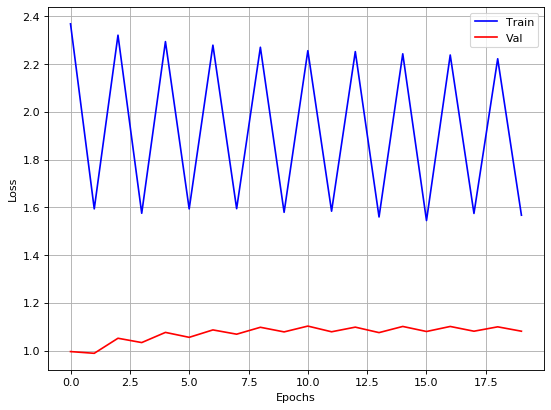

In [22]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.array(loss_values_train), 'b')
plt.plot(np.array(loss_values_val), 'r')
plt.legend(['Train','Val'])
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('train_curve_MS-POS-v1.png')
plt.show()

In [23]:
corr = 0.0
model_slave.eval()
with torch.no_grad():
  for ib,sample in enumerate(test_loader):
    
    sample, target, path = sample
    data_input = torch.as_tensor(sample[:,:,:,:])
    data_output = torch.as_tensor(target)

    data_input = data_input.to(device, dtype=torch.float)
    data_output = data_output.to(device, dtype=torch.long)

    output = model_slave(data_input)
    _, preds = torch.max(output,dim=1)
    corr += (torch.sum(preds == data_output.data)).data.item()

print('Test Accuracy Slave: {:.2f}%'.format(corr*100.0/len(tset)))

Test Accuracy Slave: 59.41%


In [31]:
LEARNINGRATE = 1e-3
GAMMA = 0.7
NUMEPOCHS = 5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_slave = PoorNet(True, WINDOW=2)
print('Running on',device)
print('Building Slave model..')
model_slave.to(device)
print('Model Built.')

FILE = 'weights-poor/Model_best_val_quicksave.pt'

model_slave.load_state_dict(torch.load(FILE,map_location='cuda:0'))
model_slave.eval()


print('Initializing optimizer and scheduler..')

criterion = torch.nn.NLLLoss()
optimizer = optim.RAdam(model_slave.parameters(), lr = LEARNINGRATE)             # OR RAdam/DiffGrad/etc
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = GAMMA)

print('Optimizer and scheduler initialized.')

print('Printing Parameters')
for name, param in model_slave.named_parameters():
    if param.requires_grad:
        print(name)
print('---Printing Parameters Finished!---')

Running on cuda:0
Building Slave model..
Model Built.
Initializing optimizer and scheduler..
Optimizer and scheduler initialized.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
---Printing Parameters Finished!---


In [32]:
top_n = 5
min_val_loss = float('inf')

loss_values_train = []
loss_values_val = []

BATCHSIZE = 128
print('Batch Size = ',BATCHSIZE)

for epoch in range(1,NUMEPOCHS+1):
    start_time = time.time()
    
    model_slave.train()
    runloss = 0.0
    tacc = 0
    
    mode = 'Forced Epoch'
    for i,sample in enumerate(train_loader):
        
        sample, t, p  = sample

        data_input = sample.numpy()
        data_output = t

        for j in range(BATCHSIZE):
            try:
                order = np.argsort(analyzis[BATCHSIZE*i+j])[::-1]
            except IndexError as error:
                break

            for k in order[top_n:]:
                data_input[j,:,k,:] = np.zeros((1,1,1,300)) 


        data_input = torch.as_tensor(data_input)
        data_output = torch.as_tensor(data_output)

        data_input = data_input.to(device, dtype=torch.float)  #, dtype=torch.float
        data_output = data_output.to(device, dtype=torch.long)    #, dtype=torch.long

        output = model_slave(data_input) 
        _, preds = torch.max(output, 1)
        
        #print(output.shape)
        #print(data_output.shape)

        loss = criterion(output, data_output)
        runloss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        runloss += loss.item() * data_input.size(0)
        tacc += (torch.sum(preds == data_output.data)).data.item()

    runloss /= (train_points) 
    tacc = tacc*100.0/ (train_points)

    loss_values_train.append(runloss)
    
    model_slave.eval()

    val_loss = 0
    corr = 0
    
    with torch.no_grad():
        for data_input, data_output, pa  in validation_loader:
            
            #sample, target, path = sample
            #data_input = torch.as_tensor(sample['matrix'][:,None,:,:])
            #data_output = torch.as_tensor(sample['class'][:,0])

            data_input = data_input.to(device, dtype=torch.float)
            data_output = data_output.to(device, dtype=torch.long)

            output = model_slave(data_input)
            _, preds = torch.max(output,dim=1)
            
            loss = criterion(output, data_output)
            val_loss += loss.item()* data_input.size(0)
            corr += (torch.sum(preds == data_output.data)).data.item()
            
    val_loss /= val_points
    corr = corr*100.0/val_points
    loss_values_val.append(val_loss)

    if val_loss <= min_val_loss:
        min_val_loss = val_loss
        torch.save(model_slave.state_dict(), 'integrated-v2_POS/Model_best_val_quicksave.pt')

    
    stop_time = time.time()
    time_el = int(stop_time-start_time)
    

    print('epoch [{}/{}] '.format(epoch, NUMEPOCHS)+mode+' loss:{:.7f}, train acc:{:.4f}, val loss:{:.7f}, val acc:{:.4f} in {}h {}m {}s'.format(
                                                                                runloss, tacc, val_loss, corr,
                                                                                time_el//3600,
                                                                                (time_el%3600)//60,
                                                                               time_el%60))
    
    torch.save(model_slave.state_dict(), 'integrated-v2_POS/Model_quicksave'+str(epoch)+'.pt')
    scheduler.step()
    

Batch Size =  128
epoch [1/5] Forced Epoch loss:2.9811157, train acc:14.2731, val loss:0.9193615, val acc:76.1715 in 0h 0m 28s
epoch [2/5] Forced Epoch loss:2.9640325, train acc:13.7981, val loss:0.9297279, val acc:75.4200 in 0h 0m 30s
epoch [3/5] Forced Epoch loss:2.9387834, train acc:13.8422, val loss:0.9390122, val acc:75.1105 in 0h 0m 31s
epoch [4/5] Forced Epoch loss:2.9256190, train acc:14.3836, val loss:0.9459236, val acc:74.3148 in 0h 0m 30s
epoch [5/5] Forced Epoch loss:2.9128568, train acc:14.6045, val loss:0.9525132, val acc:73.5190 in 0h 0m 28s


In [33]:
corr = 0.0
model_slave.eval()
with torch.no_grad():
  for ib,sample in enumerate(test_loader):
    
    sample, target, path = sample
    data_input = torch.as_tensor(sample[:,:,:,:])
    data_output = torch.as_tensor(target)

    data_input = data_input.to(device, dtype=torch.float)
    data_output = data_output.to(device, dtype=torch.long)

    output = model_slave(data_input)
    _, preds = torch.max(output,dim=1)
    corr += (torch.sum(preds == data_output.data)).data.item()

print('Test Accuracy Slave: {:.2f}%'.format(corr*100.0/len(tset)))

Test Accuracy Slave: 57.55%
